# Method 9 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

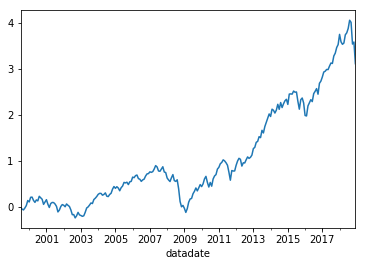

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.142058
2000-12-31   -0.030534
2001-12-31   -0.048617
2002-12-31   -0.212298
2003-12-31    0.481197
2004-12-31    0.176531
2005-12-31    0.077271
2006-12-31    0.108665
2007-12-31    0.013090
2008-12-31   -0.407981
2009-12-31    0.436845
2010-12-31    0.226167
2011-12-31   -0.022005
2012-12-31    0.193125
2013-12-31    0.419340
2014-12-31    0.105595
2015-12-31   -0.024192
2016-12-31    0.145679
2017-12-31    0.212469
2018-12-31   -0.091705
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2879.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.84e-194
Time:                        21:03:32   Log-Likelihood:                 832.31
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.706      0.000       0.001       0.003
mktrf          1.0152      0.013     78.005      0.000       0.990       1.041
me             0.2941      0.015     19.428      0.000       0.264       0.324
ia             0.0564      0.023      2.453      0.015       0.011       0.102
roe           -0.0705      0.020     -3.581      0.000      -0.109      -0.032
==============================================================================
Omnibus:                       27.114   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.843
Skew:                          -0.104   Prob(JB):                     4.30e-31
Kurtosis:                       6.781   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1632.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.44e-167
Time:                        21:03:32   Log-Likelihood:                 832.31
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.656      0.000       0.001       0.003
mktrf          1.0152      0.016     63.667      0.000       0.984       1.046
me             0.2941      0.022     13.092      0.000       0.250       0.338
ia             0.0564      0.046      1.238      0.216      -0.033       0.146
roe           -0.0705      0.029     -2.433      0.015      -0.127      -0.014
==============================================================================
Omnibus:                       27.114   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.843
Skew:                          -0.104   Prob(JB):                     4.30e-31
Kurtosis:                       6.781   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1998.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.68e-177
Time:                        21:03:32   Log-Likelihood:                 832.31
No. Observations:                 234   AIC:                            -1655.
Df Residuals:                     229   BIC:                            -1637.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.936      0.000       0.001       0.003
mktrf          1.0152      0.015     66.323      0.000       0.985       1.045
me             0.2941      0.022     13.657      0.000       0.252       0.336
ia             0.0564      0.047      1.195      0.232      -0.036       0.149
roe           -0.0705      0.032     -2.188      0.029      -0.134      -0.007
==============================================================================
Omnibus:                       27.114   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.843
Skew:                          -0.104   Prob(JB):                     4.30e-31
Kurtosis:                       6.781   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1910.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.37e-184
Time:                        21:03:32   Log-Likelihood:                 811.40
No. Observations:                 234   AIC:                            -1611.
Df Residuals:                     228   BIC:                            -1590.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.670      0.000       0.001       0.003
mktrf          1.0331      0.014     72.296      0.000       1.005       1.061
smb            0.3208      0.019     17.014      0.000       0.284       0.358
hml            0.0191      0.022      0.859      0.391      -0.025       0.063
rmw           -0.0434      0.025     -1.727      0.085      -0.093       0.006
cma            0.0571      0.032      1.786      0.075      -0.006       0.120
==============================================================================
Omnibus:                       27.386   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.964
Skew:                           0.069   Prob(JB):                     2.02e-32
Kurtosis:                       6.867   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1517.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.63e-173
Time:                        21:03:32   Log-Likelihood:                 811.40
No. Observations:                 234   AIC:                            -1611.
Df Residuals:                     228   BIC:                            -1590.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.469      0.001       0.001       0.003
mktrf          1.0331      0.018     58.256      0.000       0.998       1.068
smb            0.3208      0.024     13.507      0.000       0.274       0.367
hml            0.0191      0.049      0.386      0.699      -0.078       0.116
rmw           -0.0434      0.032     -1.372      0.170      -0.105       0.019
cma            0.0571      0.050      1.146      0.252      -0.041       0.155
==============================================================================
Omnibus:                       27.386   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.964
Skew:                           0.069   Prob(JB):                     2.02e-32
Kurtosis:                       6.867   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2041.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.47e-187
Time:                        21:03:32   Log-Likelihood:                 811.40
No. Observations:                 234   AIC:                            -1611.
Df Residuals:                     228   BIC:                            -1590.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.440      0.001       0.001       0.003
mktrf          1.0331      0.017     60.671      0.000       1.000       1.066
smb            0.3208      0.024     13.545      0.000       0.274       0.367
hml            0.0191      0.051      0.371      0.711      -0.082       0.120
rmw           -0.0434      0.035     -1.254      0.210      -0.111       0.024
cma            0.0571      0.048      1.179      0.238      -0.038       0.152
==============================================================================
Omnibus:                       27.386   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.964
Skew:                           0.069   Prob(JB):                     2.02e-32
Kurtosis:                       6.867   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2147.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.25e-180
Time:                        21:03:32   Log-Likelihood:                 798.78
No. Observations:                 234   AIC:                            -1588.
Df Residuals:                     229   BIC:                            -1570.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.803      0.000       0.001       0.003
mktrf          1.0285      0.014     74.376      0.000       1.001       1.056
smb            0.3252      0.017     18.842      0.000       0.291       0.359
hml            0.0865      0.017      5.046      0.000       0.053       0.120
umd           -0.0225      0.011     -1.998      0.047      -0.045      -0.000
==============================================================================
Omnibus:                       26.544   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.470
Skew:                           0.100   Prob(JB):                     1.04e-29
Kurtosis:                       6.695   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1753.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.05e-170
Time:                        21:03:32   Log-Likelihood:                 798.78
No. Observations:                 234   AIC:                            -1588.
Df Residuals:                     229   BIC:                            -1570.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.212      0.001       0.001       0.003
mktrf          1.0285      0.019     54.764      0.000       0.992       1.065
smb            0.3252      0.023     14.298      0.000       0.281       0.370
hml            0.0865      0.049      1.763      0.078      -0.010       0.183
umd           -0.0225      0.021     -1.067      0.286      -0.064       0.019
==============================================================================
Omnibus:                       26.544   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.470
Skew:                           0.100   Prob(JB):                     1.04e-29
Kurtosis:                       6.695   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2175.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.54e-181
Time:                        21:03:32   Log-Likelihood:                 798.78
No. Observations:                 234   AIC:                            -1588.
Df Residuals:                     229   BIC:                            -1570.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.184      0.001       0.001       0.003
mktrf          1.0285      0.016     64.083      0.000       0.997       1.060
smb            0.3252      0.024     13.776      0.000       0.279       0.372
hml            0.0865      0.054      1.597      0.110      -0.020       0.193
umd           -0.0225      0.017     -1.307      0.191      -0.056       0.011
==============================================================================
Omnibus:                       26.544   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.470
Skew:                           0.100   Prob(JB):                     1.04e-29
Kurtosis:                       6.695   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1270.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.99e-94
Time:                        21:03:33   Log-Likelihood:                 406.83
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     115   BIC:                            -789.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.691      0.000       0.001       0.005
mktrf          1.0196      0.021     47.489      0.000       0.977       1.062
me             0.2754      0.021     12.986      0.000       0.233       0.317
ia             0.0935      0.033      2.815      0.006       0.028       0.159
roe           -0.0707      0.029     -2.407      0.018      -0.129      -0.013
==============================================================================
Omnibus:                       11.052   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.972
Skew:                          -0.134   Prob(JB):                     8.43e-07
Kurtosis:                       5.350   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     898.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-85
Time:                        21:03:33   Log-Likelihood:                 406.83
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     115   BIC:                            -789.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.692      0.000       0.001       0.004
mktrf          1.0196      0.027     37.363      0.000       0.966       1.073
me             0.2754      0.024     11.570      0.000       0.229       0.322
ia             0.0935      0.051      1.829      0.067      -0.007       0.194
roe           -0.0707      0.036     -1.972      0.049      -0.141      -0.000
==============================================================================
Omnibus:                       11.052   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.972
Skew:                          -0.134   Prob(JB):                     8.43e-07
Kurtosis:                       5.350   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1427.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.60e-97
Time:                        21:03:33   Log-Likelihood:                 406.83
No. Observations:                 120   AIC:                            -803.7
Df Residuals:                     115   BIC:                            -789.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      3.801      0.000       0.001       0.004
mktrf          1.0196      0.024     43.075      0.000       0.973       1.066
me             0.2754      0.024     11.685      0.000       0.229       0.322
ia             0.0935      0.047      2.002      0.045       0.002       0.185
roe           -0.0707      0.038     -1.870      0.062      -0.145       0.003
==============================================================================
Omnibus:                       11.052   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               27.972
Skew:                          -0.134   Prob(JB):                     8.43e-07
Kurtosis:                       5.350   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     822.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.17e-87
Time:                        21:03:33   Log-Likelihood:                 394.98
No. Observations:                 120   AIC:                            -778.0
Df Residuals:                     114   BIC:                            -761.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.477      0.001       0.001       0.005
mktrf          1.0708      0.025     42.662      0.000       1.021       1.121
smb            0.3186      0.028     11.209      0.000       0.262       0.375
hml           -0.0076      0.035     -0.218      0.828      -0.077       0.061
rmw           -0.0083      0.041     -0.202      0.840      -0.090       0.073
cma            0.1233      0.045      2.739      0.007       0.034       0.212
==============================================================================
Omnibus:                       12.421   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.321
Skew:                          -0.141   Prob(JB):                     2.14e-08
Kurtosis:                       5.643   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     952.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.43e-91
Time:                        21:03:33   Log-Likelihood:                 394.98
No. Observations:                 120   AIC:                            -778.0
Df Residuals:                     114   BIC:                            -761.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.466      0.001       0.001       0.005
mktrf          1.0708      0.035     30.980      0.000       1.003       1.139
smb            0.3186      0.037      8.704      0.000       0.247       0.390
hml           -0.0076      0.081     -0.094      0.926      -0.167       0.152
rmw           -0.0083      0.064     -0.131      0.896      -0.133       0.116
cma            0.1233      0.060      2.049      0.040       0.005       0.241
==============================================================================
Omnibus:                       12.421   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.321
Skew:                          -0.141   Prob(JB):                     2.14e-08
Kurtosis:                       5.643   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1653.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.39e-104
Time:                        21:03:33   Log-Likelihood:                 394.98
No. Observations:                 120   AIC:                            -778.0
Df Residuals:                     114   BIC:                            -761.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      3.635      0.000       0.001       0.005
mktrf          1.0708      0.033     32.353      0.000       1.006       1.136
smb            0.3186      0.037      8.517      0.000       0.245       0.392
hml           -0.0076      0.087     -0.088      0.930      -0.177       0.162
rmw           -0.0083      0.070     -0.119      0.905      -0.146       0.129
cma            0.1233      0.058      2.134      0.033       0.010       0.236
==============================================================================
Omnibus:                       12.421   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.321
Skew:                          -0.141   Prob(JB):                     2.14e-08
Kurtosis:                       5.643   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     890.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.73e-85
Time:                        21:03:33   Log-Likelihood:                 386.07
No. Observations:                 120   AIC:                            -762.1
Df Residuals:                     115   BIC:                            -748.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.797      0.000       0.002       0.005
mktrf          1.0421      0.022     46.342      0.000       0.998       1.087
smb            0.3171      0.026     12.387      0.000       0.266       0.368
hml            0.1045      0.026      4.075      0.000       0.054       0.155
umd           -0.0191      0.016     -1.207      0.230      -0.050       0.012
==============================================================================
Omnibus:                       11.964   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               34.061
Skew:                          -0.083   Prob(JB):                     4.02e-08
Kurtosis:                       5.605   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1056.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.25e-89
Time:                        21:03:33   Log-Likelihood:                 386.07
No. Observations:                 120   AIC:                            -762.1
Df Residuals:                     115   BIC:                            -748.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.983      0.000       0.002       0.005
mktrf          1.0421      0.030     34.366      0.000       0.983       1.102
smb            0.3171      0.028     11.200      0.000       0.262       0.373
hml            0.1045      0.063      1.671      0.095      -0.018       0.227
umd           -0.0191      0.025     -0.757      0.449      -0.069       0.030
==============================================================================
Omnibus:                       11.964   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               34.061
Skew:                          -0.083   Prob(JB):                     4.02e-08
Kurtosis:                       5.605   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1480.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.14e-98
Time:                        21:03:33   Log-Likelihood:                 386.07
No. Observations:                 120   AIC:                            -762.1
Df Residuals:                     115   BIC:                            -748.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      4.261      0.000       0.002       0.005
mktrf          1.0421      0.024     44.012      0.000       0.996       1.089
smb            0.3171      0.030     10.742      0.000       0.259       0.375
hml            0.1045      0.068      1.543      0.123      -0.028       0.237
umd           -0.0191      0.020     -0.970      0.332      -0.058       0.019
==============================================================================
Omnibus:                       11.964   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               34.061
Skew:                          -0.083   Prob(JB):                     4.02e-08
Kurtosis:                       5.605   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2473.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.97e-106
Time:                        21:03:33   Log-Likelihood:                 455.67
No. Observations:                 114   AIC:                            -901.3
Df Residuals:                     109   BIC:                            -887.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.729      0.000       0.001       0.003
mktrf          1.0117      0.013     75.709      0.000       0.985       1.038
me             0.3335      0.021     16.165      0.000       0.293       0.374
ia            -0.0732      0.029     -2.558      0.012      -0.130      -0.016
roe           -0.1229      0.025     -4.889      0.000      -0.173      -0.073
==============================================================================
Omnibus:                        9.115   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.923
Skew:                          -0.638   Prob(JB):                       0.0115
Kurtosis:                       3.502   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3908.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.10e-116
Time:                        21:03:33   Log-Likelihood:                 455.67
No. Observations:                 114   AIC:                            -901.3
Df Residuals:                     109   BIC:                            -887.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.021      0.000       0.001       0.003
mktrf          1.0117      0.010     96.622      0.000       0.991       1.032
me             0.3335      0.016     20.668      0.000       0.302       0.365
ia            -0.0732      0.030     -2.437      0.015      -0.132      -0.014
roe           -0.1229      0.024     -5.078      0.000      -0.170      -0.075
==============================================================================
Omnibus:                        9.115   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.923
Skew:                          -0.638   Prob(JB):                       0.0115
Kurtosis:                       3.502   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4477.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.04e-120
Time:                        21:03:33   Log-Likelihood:                 455.67
No. Observations:                 114   AIC:                            -901.3
Df Residuals:                     109   BIC:                            -887.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.912      0.000       0.001       0.003
mktrf          1.0117      0.010    100.449      0.000       0.992       1.031
me             0.3335      0.016     20.817      0.000       0.302       0.365
ia            -0.0732      0.033     -2.234      0.026      -0.137      -0.009
roe           -0.1229      0.023     -5.407      0.000      -0.168      -0.078
==============================================================================
Omnibus:                        9.115   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.923
Skew:                          -0.638   Prob(JB):                       0.0115
Kurtosis:                       3.502   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2536.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.35e-110
Time:                        21:03:33   Log-Likelihood:                 470.20
No. Observations:                 114   AIC:                            -928.4
Df Residuals:                     108   BIC:                            -912.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.973      0.051   -3.63e-06       0.002
mktrf          1.0187      0.011     90.376      0.000       0.996       1.041
smb            0.3082      0.018     16.842      0.000       0.272       0.344
hml            0.0148      0.023      0.635      0.527      -0.031       0.061
rmw           -0.1829      0.029     -6.399      0.000      -0.240      -0.126
cma           -0.0961      0.036     -2.648      0.009      -0.168      -0.024
==============================================================================
Omnibus:                       10.248   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.281
Skew:                          -0.681   Prob(JB):                      0.00585
Kurtosis:                       3.557   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2773.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.77e-112
Time:                        21:03:33   Log-Likelihood:                 470.20
No. Observations:                 114   AIC:                            -928.4
Df Residuals:                     108   BIC:                            -912.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.955      0.051   -1.81e-06       0.002
mktrf          1.0187      0.010    106.821      0.000       1.000       1.037
smb            0.3082      0.016     19.356      0.000       0.277       0.339
hml            0.0148      0.019      0.781      0.435      -0.022       0.052
rmw           -0.1829      0.025     -7.176      0.000      -0.233      -0.133
cma           -0.0961      0.039     -2.461      0.014      -0.173      -0.020
==============================================================================
Omnibus:                       10.248   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.281
Skew:                          -0.681   Prob(JB):                      0.00585
Kurtosis:                       3.557   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     4365.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.41e-123
Time:                        21:03:33   Log-Likelihood:                 470.20
No. Observations:                 114   AIC:                            -928.4
Df Residuals:                     108   BIC:                            -912.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.796      0.073   -7.24e-05       0.002
mktrf          1.0187      0.008    125.166      0.000       1.003       1.035
smb            0.3082      0.015     20.746      0.000       0.279       0.337
hml            0.0148      0.018      0.812      0.417      -0.021       0.051
rmw           -0.1829      0.026     -6.944      0.000      -0.234      -0.131
cma           -0.0961      0.040     -2.395      0.017      -0.175      -0.017
==============================================================================
Omnibus:                       10.248   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.281
Skew:                          -0.681   Prob(JB):                      0.00585
Kurtosis:                       3.557   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2158.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.19e-103
Time:                        21:03:33   Log-Likelihood:                 447.99
No. Observations:                 114   AIC:                            -886.0
Df Residuals:                     109   BIC:                            -872.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.842      0.402      -0.001       0.001
mktrf          1.0315      0.014     76.148      0.000       1.005       1.058
smb            0.3503      0.021     16.586      0.000       0.308       0.392
hml            0.0076      0.022      0.351      0.726      -0.035       0.051
umd           -0.0378      0.016     -2.302      0.023      -0.070      -0.005
==============================================================================
Omnibus:                        4.149   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                3.529
Skew:                          -0.389   Prob(JB):                        0.171
Kurtosis:                       3.370   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1800.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-98
Time:                        21:03:33   Log-Likelihood:                 447.99
No. Observations:                 114   AIC:                            -886.0
Df Residuals:                     109   BIC:                            -872.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.822      0.411      -0.001       0.001
mktrf          1.0315      0.014     74.603      0.000       1.004       1.059
smb            0.3503      0.019     18.726      0.000       0.314       0.387
hml            0.0076      0.020      0.381      0.703      -0.032       0.047
umd           -0.0378      0.013     -2.986      0.003      -0.063      -0.013
==============================================================================
Omnibus:                        4.149   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                3.529
Skew:                          -0.389   Prob(JB):                        0.171
Kurtosis:                       3.370   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     3469.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.95e-114
Time:                        21:03:33   Log-Likelihood:                 447.99
No. Observations:                 114   AIC:                            -886.0
Df Residuals:                     109   BIC:                            -872.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.824      0.410      -0.001       0.001
mktrf          1.0315      0.013     79.920      0.000       1.006       1.057
smb            0.3503      0.014     24.728      0.000       0.323       0.378
hml            0.0076      0.017      0.452      0.651      -0.025       0.041
umd           -0.0378      0.012     -3.115      0.002      -0.062      -0.014
==============================================================================
Omnibus:                        4.149   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                3.529
Skew:                          -0.389   Prob(JB):                        0.171
Kurtosis:                       3.370   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""